In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns

### Download data from MTA

In [2]:
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt"
df = pd.read_csv(url)

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555


pseudo code
- calculate the number of people entering each station for every timestamp
    - the number of entries is cumulative (when does it reset to 0?)
- calculate the number of people exiting each station for every timestamp

In [4]:
# get rid of extra strings in columns 
df.columns = df.columns.str.replace(" ", "")

In [5]:
# Use diff() to derrive the actual number of people from the culmulative value for entries and exits for each SCP
# abs() is used to account for the turnstiles that count backwards
df['people_in'] = df.groupby(['STATION', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff().abs())
df['people_out'] = df.groupby(['STATION', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff().abs())

In [6]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415,14.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443,20.0,28.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500,79.0,57.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555,239.0,55.0


In [7]:
# show which rows are NaN - each nan is at the beginning of a new scp
df[df['people_in'].isna()].head(40)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,NaN,NaN
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6298050,1412557,NaN,NaN
84,A002,R051,02-03-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1236982,4651756,NaN,NaN
126,A002,R051,02-03-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1115712,1720977,NaN,NaN
168,A002,R051,02-03-02,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6200254,8353543,NaN,NaN
210,A002,R051,02-03-03,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,5754201,6607896,NaN,NaN
252,A002,R051,02-03-04,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7133706,3699957,NaN,NaN
294,A002,R051,02-03-05,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,11441906,1401251,NaN,NaN
336,A002,R051,02-03-06,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,8980953,499358,NaN,NaN
378,A002,R051,02-05-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,129,0,NaN,NaN


In [8]:
# Remove nan data for now
df = df.dropna()

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,ENTRIES,EXITS,people_in,people_out
count,198927.000,198927.000,198927.000,198927.000
mean,42255027.697,34442423.498,9569.588,2101.370
std,214275595.638,196509556.296,3753018.199,865850.774
min,0.000,0.000,0.000,0.000
25%,334733.000,138212.000,10.000,8.000
50%,2143919.000,1227057.000,67.000,49.000
75%,6739089.500,4570164.000,217.000,155.000
max,2129288981.000,2124055172.000,1661415925.000,386167799.000


### Incorporate Jieun's analysis and select only the top 30 stations

In [10]:
# list of top 30 stations from Jieun's notebook
stations = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '59 ST', '14 ST', '125 ST',
       '104 ST', 'TIMES SQ-42 ST', 'DEKALB AV', '86 ST', 'FRANKLIN AV',
       '145 ST', '167 ST', 'LEXINGTON AV/53', '72 ST', 'GUN HILL RD',
       'BOWLING GREEN', 'FULTON ST', 'GRD CNTRL-42 ST', '66 ST-LINCOLN',
       'KINGS HWY', 'GRAND ST', 'KINGSBRIDGE RD', '34 ST-PENN STA',
       'CHAMBERS ST', 'FORDHAM RD', '116 ST', '96 ST', '50 ST',
       'FT HAMILTON PKY']

In [11]:
# select only top 30 stations from data frame
df = df[df['STATION'].isin(stations)]

### Create a map of the top 30 stations

In [12]:
# Remove outliers
df = df[(np.abs(stats.zscore(df["people_out"])) < 3)]

### Make Graphs showing frequency for time of day and day of week 
- for now it will be a random selection of stations but we will choose the stations we want to select  

In [13]:
# Create a day of week column
df['DATE'] = pd.to_datetime(df['DATE'])
df['weekday'] = df['DATE'].dt.day_name()

In [20]:
# Remove Saturday and Sunday - we want to target commuters and street teams don't want to work on the weekend
df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

In [21]:
heat_df = df.filter(['weekday','STATION','people_out'], axis=1)
heat_df.head()

,weekday,STATION,people_out
12,Monday,59 ST,18.000
13,Monday,59 ST,3.000
14,Monday,59 ST,31.000
15,Monday,59 ST,51.000
16,Monday,59 ST,40.000


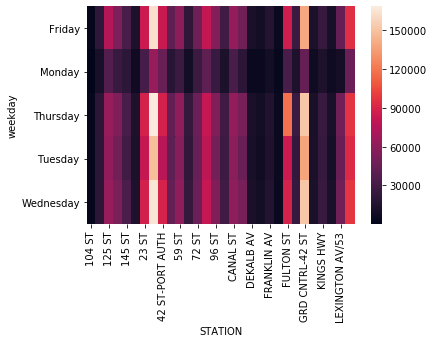

In [22]:
heat_df = heat_df.pivot_table(index='weekday', columns='STATION', values='people_out', aggfunc='sum')
sns.heatmap(heat_df)